**Author**: J W Debelius<br/>
**Date**: 27 August 2015<br/>
**virtualenv**: power play

# 1. Introduction

In [101]:
from __future__ import division

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import statsmodels.api as sms
import statsmodels.formula.api as smf

import absloute_power.traditional as trad
import absloute_power.utils as ap

from scipy.stats import norm as Z

import americangut.power_plots as pp

import pandas as pd

from skbio.stats.power import subsample_power

from absloute_power.traditional import calc_ttest_1

In [2]:
from matplotlib import rcParams



# Sets up plotting parameters so that the default setting is use to Helvetica
# in plots
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica', 'Arial']
rcParams['text.usetex'] = True

% matplotlib inline

We'll examine five common, simple statistical models where the power equation has been defined and employed. The emperical power implementations are based on the version described in [ref].

We will examine statistical power for three tests dealing with normal distributions:

* Case I t test
* Case II (independent) t test
* One way Analysis of Variance (ANOVA)
* Pearson's R
* Chi-Square

We will perform 100 simulations of statistical power, comparing the power between 5 and 50 counts, with 5 observation intervals between. We'll set the critical value at 0.05.

In [3]:
num_rounds = 100
counts = np.arange(5, 55, 10)
alpha = 0.05
distributions = {}

We'll also set a random seed, so that the results we get out are consistent.

In [4]:
np.random.seed(25)

# 2. Case I Test

A case I t-test checks if an observation is drawn from a sample. We are testing the alternatively hypotheses,

$\begin{matrix}
\textbf{H}_{0} & x = \bar{x} \\
\textbf{H}_{1} & x \neq \bar{x}\\
\end{matrix} \tag{2.1}$

where $\bar{x}$ is the mean of the population, $x$ is the value being compared to the sample, $s$ is the standard devation of the sample, and there are $n$ observations in the sample.

## 2.1 Test Statistic

The test statistic for the case I t test is given as
$t = \frac{(\bar{x} - x)\sqrt{n}}{s} \tag{2.2}$
The probability distribution follows a T distribution with $n-1$ degrees of freedom, where $n$ is the number of observations in the sample.


For the emperical test, we will use the `scipy.stats.ttest_1samp` function, which returns a p value.

In [5]:
def emp_ttest_1(sample, x0=0):
    return scipy.stats.ttest_1samp(sample, x0)[1]

## 2.2 Nonparametric Test

In [6]:
def emp_ttest_1_nonpar(sample, x0=0):
    scipy.stats.wilcoxon(sample - x0)[1]

## 2.3 Effect Size

The effect size for a one-sample t test is Cohen's d, given by equation (2.3).
$\begin{align*}
d = \frac{\bar{x} - x_{0}}{s}
\end{align*}\tag{2.3}$
For a two-tailed test, we can treat this as an absloute magnitude, and then test $t > (1 - \alpha/2)$.

In [7]:
def cohen_d_one_sample(sample, x0=0):
    x1, s1 = sample.mean(), sample.std()
    return np.absolute(x1 - x0) / s1

## 2.4 Noncentrality Paramter

The non centrality paramter for the statistic, $\lambda$ is given by
$\begin{align*}
\lambda &= \frac{t}{\sqrt{n}}\\
&=\frac{1}{\sqrt{n}}\left(\frac{(\bar{x} - x)\sqrt{n}}{s}\right )\\
&=\frac{(\bar{x} - x)}{s}
\end{align*}\tag{2.4}$

We will encorperate this in the power calculation. To allow for testing, the power calculation has been moved into a library.

## 2.5 Simulation Parameters

We'll test the set of hypotheses,

$\begin{matrix}
\textbf{H}_{0} & 0 = \bar{x} \\
\textbf{H}_{1} & 0 \neq \bar{x}\\
\end{matrix} \tag{2.5}$

where $\bar{x}$ is the mean of a sample drawn from a population.

We'll test the means between 2 and 10 with standard deviations between 5 and 15, and sample sizes between 60 and 100 observations.

In [112]:
def ttest_1_simulate(mu_lim, sigma_lim, count_lims):
    # Gets the distribution parameters
    shape = np.random.uniform(*mu_lim)
    scale = np.random.uniform(*sigma_lim)
    n = np.random.randint(*count_lims)
    
    sample = np.random.gamma(shape, scale, n)
    reindex = np.random.choice(np.arange(0, n), n/4, replace=False)
    sample[reindex] = sample[reindex] - np.random.poisson(1, n/4)
    # Draws a sample that fits the parameters
    return [shape, scale, n], [sample]

In [113]:
distributions['ttest_1'] = {'emp_test_fun': emp_ttest_1,
                            'non_test_fun': emp_ttest_1_nonpar,
                            'trad_test_fun': calc_ttest_1,
                            'sim_function': ttest_1_simulate,
                            'sim_parameters': [[0.1, 5], [0.1, 3], [125, 126]],
                            'other_sim_parameters': {},
                            'test_parameters': {'x0': 0},
                            'emp_parameters': {},
                            'effect_size': cohen_d_one_sample,
                             }

In [114]:
[shape, scale, n], sample = ttest_1_simulate([0.05, 3], [0.05, 5], [1000, 1001])

/Users/jwdebelius/.virtualenvs/power_play/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/jwdebelius/.virtualenvs/power_play/lib/python2.7/site-packages/ipykernel/__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


# 6. Building Simulations

We will now build the simulations and look at the results.

1.69188624852 4.10723524985


(array([ 149.,  239.,  163.,  123.,   97.,   71.,   47.,   38.,   29.,
          16.,    5.,    5.,    0.,    3.,    0.,    0.,    0.,    1.,
           1.,    0.,    0.,    0.,    0.,    0.,    0.]),
 array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
        34, 36, 38, 40, 42, 44, 46, 48, 50]),
 <a list of 25 Patch objects>)

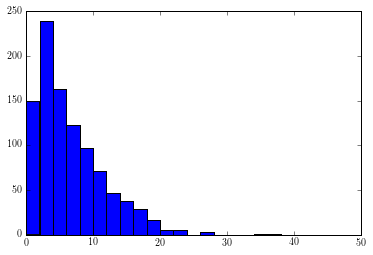

In [115]:
print shape, scale
plt.hist(sample, np.arange(0, 51, 2))

In [123]:
# %%time

# for k, params in distributions.iteritems():
for k, params in [('ttest_1', distributions['ttest_1'])]:
    params['pop_params'] = []
    params['sample'] = []
    params['effs'] = []
    params['test'] = []
    params['trad'] = []
    params['empp'] = []
    params['empn'] = []
    params['extp'] = []
    params['extn'] = []
    
    for i in xrange(100):
        # Calculates the samples
        pop_params, samples = params['sim_function'](*params['sim_parameters'], **params['other_sim_parameters'])
        params['pop_params'].append(pop_params)
        params['sample'].append(samples)
        
        # Calculates the traditional power
        test_power = params['trad_test_fun'](*samples, counts=counts, **params['test_parameters'])
        params['test'].append(test_power)
        
        # Calculates Cohen's effect
        if 'effect_size' in params:
            cohen_eff = params['effect_size'](*samples)
        else:
            cohen_eff = None
        
        # Extrapolates the effect from the test
        test_eff = ap.z_effect(counts, test_power)
        
        trad_power = ap.z_power(counts, test_eff.mean())
        params['trad'].append(trad_power)
        
         # Calculates the emprical power using a nonparametric test
        nempr_power, nempr_counts = subsample_power(lambda x: params['emp_test_fun'](*x, **params['test_parameters']),
                                                  samples,
                                                  min_counts=5,
                                                  max_counts=55,
                                                  counts_interval=10,
                                                  num_runs=5,
                                                  num_iter=1000,
                                                  **params['emp_parameters'])
        # Calculates the nonparametric effect
        nonp_eff = ap.z_effect(nempr_counts, nempr_power)
        nonf_eff = pp.collate_effect_size([nempr_counts], [nempr_power], 0.05)
        next_power = ap.z_power(counts, nonp_eff.mean())
        params['empn'].append(nempr_power)
        params['extn'].append(next_power)
        

        # Updates the information
        params['effs'].append([cohen_eff, test_eff, nonp_eff, nonf_eff])
    distributions[k] = params
    print k

ttest_1


/Users/jwdebelius/.virtualenvs/power_play/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/jwdebelius/.virtualenvs/power_play/lib/python2.7/site-packages/ipykernel/__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [124]:
# fig1 = plt.figure()
# fig1.set_size_inches((4, 4))

samples = distributions['ttest_1']['sample']

effs = distributions['ttest_1']['effs']

test = np.vstack(distributions['ttest_1']['test'])
trad = np.vstack(distributions['ttest_1']['trad'])
nemp = np.vstack([d.mean(0) for d in distributions['ttest_1']['empn']])
extn = np.vstack(distributions['ttest_1']['extn'])


In [ ]:
from matplotlib import cm

means = np.array([np.mean(e) for e in zip(*effs)[2]])
means_order = np.argsort(means)

num_colors=len(means_order) # cats is a vector of the number of groups
blues = cm.get_cmap('Greys_r') # Colormap name
greens = cm.get_cmap('Greys_r')
reds = cm.get_cmap('Greys_r')
purples = cm.get_cmap('Greys_r')
new_blues = np.array([list(blues((1.*i)/(num_colors))) for i in xrange(num_colors)])
new_green = np.array([list(greens((1.*i)/(num_colors))) for i in xrange(num_colors)])
new_reds = np.array([list(reds((1.*i)/(num_colors))) for i in xrange(num_colors)])
new_purples = np.array([list(purples((1.*i)/(num_colors))) for i in xrange(num_colors)])

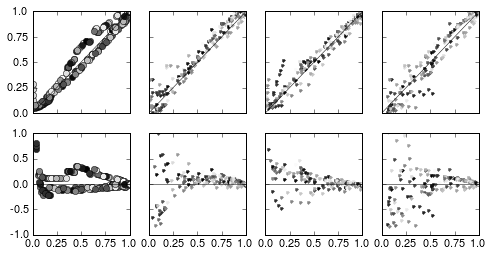

In [ ]:
fig = plt.figure()

ax1 = fig.add_subplot(2, 4, 1)
ax2 = fig.add_subplot(2, 4, 2)
ax3 = fig.add_subplot(2, 4, 3)
ax4 = fig.add_subplot(2, 4, 4)
ax5 = fig.add_subplot(2, 4, 5)
ax6 = fig.add_subplot(2, 4, 6)
ax7 = fig.add_subplot(2, 4, 7)
ax8 = fig.add_subplot(2, 4, 8)

for idx in xrange(len(means_order)):
    loc = means_order[idx]
    ax1.plot(distributions['ttest_1']['test'][idx], 
             distributions['ttest_1']['trad'][idx],
            'o', color=new_green[loc])
    ax5.plot(distributions['ttest_1']['test'][idx],
             (-distributions['ttest_1']['test'][idx] +
              distributions['ttest_1']['trad'][idx]) /
             distributions['ttest_1']['test'][idx],
            'o', color=new_green[loc])
#     ax1.set_axis_bgcolor('k')
    ax2.plot(distributions['ttest_1']['test'][idx],
             np.mean(distributions['ttest_1']['empn'][idx], 0),
             '.', color=new_blues[loc])
#     ax2.set_axis_bgcolor('k')
    ax6.plot(distributions['ttest_1']['test'][idx],
             (-distributions['ttest_1']['test'][idx] +
              np.mean(distributions['ttest_1']['empn'][idx], 0)) /
             distributions['ttest_1']['test'][idx],
            '.', color=new_blues[loc])
    
    ax3.plot(distributions['ttest_1']['test'][idx],
             distributions['ttest_1']['extn'][idx],
             '.', color=new_reds[loc])
    
    ax7.plot(distributions['ttest_1']['test'][idx],
             (-distributions['ttest_1']['test'][idx] +
              distributions['ttest_1']['extn'][idx]) /
             distributions['ttest_1']['test'][idx],
            '.', color=new_reds[loc])
    
# #     ax3.set_axis_bgcolor('k')
    ax4.plot(distributions['ttest_1']['extn'][idx],
             np.mean(distributions['ttest_1']['empn'][idx], 0),
             '.', color=new_purples[loc])
    
    ax8.plot(distributions['ttest_1']['extn'][idx],
             (np.mean(distributions['ttest_1']['empn'][idx], 0) -
              distributions['ttest_1']['extn'][idx]) /
              distributions['ttest_1']['extn'][idx],
            '.', color=new_purples[loc])
    
for i, ax in enumerate(fig.axes):
    ax.set_xticks(np.arange(0, 1.1, 0.25))
    if i < 4:
        ax.set_yticks(np.arange(0, 1.1, 0.25))
        ax.set_yticklabels('')
        ax.set_xticklabels('')
        ax.plot([0, 1], [0, 1], 'k-', linewidth=0.5)
    else:
        ax.set_ylim([-1, 1])
        ax.set_yticks(np.arange(-1, 1.1, 0.5))
        ax.set_yticklabels('')
        ax.set_xticklabels(np.arange(0, 1.1, 0.25), size=11)
        ax.plot([0, 1], [0, 0], 'k-', linewidth=0.5)
        
ax1.set_yticklabels(np.arange(0, 1.1, 0.25), size=11)
ax5.set_yticklabels(np.arange(-1, 1.1, 0.5), size=11)


fig.set_size_inches((8, 4))

In [ ]:
means[means_order] / np.sqrt(2)

In [ ]:
np.mean([ap.z_power(counts, e) for e in zip(*effs)[1][0]], 0)

In [ ]:
trad_mean = np.concatenate([ap.z_power(counts, np.mean(eff)) for eff in zip(*effs)[1]])
trad_conf = np.concatenate([(ap.z_power(counts, np.mean(eff)) + np.std(eff) / np.sqrt(len(eff)) * scipy.stats.t.ppf(0.975, len(eff) - 1)) - 
                            ap.z_power(counts, np.mean(eff)) for eff in zip(*effs)[1]])

In [ ]:
tst_trd_m = np.concatenate([np

In [ ]:
check = [d.mean(0) for d in distributions['ttest_1']['empn']]

In [ ]:
np.hstack(check)

In [ ]:
empn_mean = [d.mean(0) for d in distributions['ttest_1']['empn']]
empn_conf = np.concatenate([d.std(0) / np.sqrt(5) * scipy.stats.t.ppf(0.975, 2) for d in distributions['ttest_1']['empn']])

emntrd_rt = np.concatenate([np.mean((np.vstack([t] * 3) - d) / np.vstack([t] * 3), 0) / np.sqrt(len(d))
                           for (t, d) in zip(*(distributions['ttest_1']['trad'], distributions['ttest_1']['empn']))])
emntrd_ci = np.concatenate([np.std((np.vstack([t] * 3) - d) / np.vstack([t] * 3), 0) / np.sqrt(len(d)) * scipy.stats.t.ppf(0.975, len(d)-1) 
                            for (t, d) in zip(*(distributions['ttest_1']['trad'], distributions['ttest_1']['empn']))])

In [ ]:
extn_mean = np.concatenate([ap.z_power(counts, np.mean(eff)) for eff in zip(*effs)[3]])
extn_conf = np.concatenate([ap.z_power(counts, np.mean(eff) + np.std(eff) / np.sqrt(len(eff)) * scipy.stats.t.ppf(0.975, len(eff) - 1)) - 
                            ap.z_power(counts, np.mean(eff)) for eff in zip(*effs)[3]])
exntrd_r = []
exntrd_c = []
for i, (t, eff) in enumerate(zip(*(distributions['ttest_1']['trad'], distributions['ttest_1']['effs']))):
    if len(eff[3]) > 0:
        exntrd_r.append(np.mean([(ap.z_power(counts, e) - t) / t for e in eff[3]], 0))
        exntrd_c.append(np.std([(ap.z_power(counts, e) - t) / t for e in eff[3]], 0) / np.sqrt(len(eff[3])) * scipy.stats.t.ppf(0.975, len(eff[3] -1)))
    else:
        exntrd_r.append(np.nan*np.ones(counts.shape))
        exntrd_c.append(np.nan*np.ones(counts.shape))
    
exntrd_r = np.concatenate(exntrd_r)
exntrd_c = np.concatenate(exntrd_c)

In [ ]:
test.shape

In [ ]:
empn_mean.shape

In [ ]:
fig2 = plt.figure()

ax1 = fig2.add_subplot(2, 3, 1)
ax2 = fig2.add_subplot(2, 3, 2)
ax3 = fig2.add_subplot(2, 3, 3)
ax4 = fig2.add_subplot(2, 3, 4)
ax5 = fig2.add_subplot(2, 3, 5)
ax6 = fig2.add_subplot(2, 3, 6)

ax1.errorbar(test, trad_mean, trad_conf, marker='', linestyle='none', color='#bdbdbd')
ax1.plot(test, trad_mean, 'o', mfc='none', ms=4, alpha=0.2, mec='#252525')

ax3.plot(test, empn_mean)

# ax3.errorbar(test, empn_mean, empn_conf, marker='', linestyle='none', color='#fb9a99')
# ax3.plot(test, empn_mean, 'o', mfc='none', ms=4, alpha=0.2, mec='#e31a1c')

In [ ]:
ax2.errorbar(trad, empn_mean, yerr=empn_conf, marker='', linestyle='none', color='#a6cee3')
ax2.plot(trad, empn_mean, 'o', mec='#1f78b4', mfc='none', markersize=4, alpha=0.2)

ax2.set_xlim([-0.05, 1.05])
ax2.set_ylim([-0.05, 1.1])
ax2.plot([-0.1, 1.1], [-0.1, 1.1], 'k-')
ax2.set_xticks(np.arange(0, 1.1, 0.25))
ax2.set_yticks(np.arange(0, 1.1, 0.25))
ax2.set_xticklabels('')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.yaxis.set_ticks_position('left')
ax2.xaxis.set_ticks_position('bottom')
ax2.get_xaxis().set_tick_params(direction='out')
ax2.get_yaxis().set_tick_params(direction='out')
ax2.set_yticklabels(ax2.get_yticks(), size=10)
ax2.set_ylabel('Emperical Power', size=12)
ax2.text(0.05, 0.9, '(A)', size=15)

ax4.errorbar(trad, emntrd_rt, yerr=emntrd_ci, marker='', linestyle='none', color='#a6cee3')
ax4.plot(trad, emntrd_rt, 'o', mec='#1f78b4', mfc='none', markersize=4, alpha=0.2)
ax4.plot([0, 1], [0, 0], 'k-')
ax4.set_ylim([-1, 1])
ax4.set_xticks(np.arange(0, 1.1, 0.25))
ax4.set_yticks(np.arange(-1, 1.1, 0.5))
# ax4.set_xticklabels('')
ax4.set_yticklabels(ax4.get_yticks(), size=10)
ax4.set_xticklabels(ax4.get_xticks(), size=10)
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)
ax4.yaxis.set_ticks_position('left')
ax4.xaxis.set_ticks_position('bottom')
ax4.get_xaxis().set_tick_params(direction='out')
ax4.get_yaxis().set_tick_params(direction='out')
ax4.set_ylabel('Relative Difference', size=12)
ax4.text(0.05, 0.8, '(C)', size=15)

ax3.errorbar(trad, extn_mean, yerr=extn_conf, marker='', linestyle='none', color='#fb9a99')
ax3.plot(trad, extn_mean, 'o', mec='#e31a1c', mfc='none', markersize=4)

ax3.plot([0, 1], [0, 1], 'k-')
ax3.set_xticks(np.arange(0, 1.1, 0.25))
ax3.set_yticks(np.arange(0, 1.1, 0.25))
ax3.set_yticklabels('')
ax3.set_xticklabels('')
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.yaxis.set_ticks_position('left')
ax3.xaxis.set_ticks_position('bottom')
ax3.get_xaxis().set_tick_params(direction='out')
ax3.get_yaxis().set_tick_params(direction='out')
ax3.text(0.05, 0.9, '(B)', size=15)


ax5.errorbar(trad, exntrd_r, yerr=exntrd_c, marker='', linestyle='none', color='#fb9a99')
ax5.plot(trad, exntrd_r, 'o', mec='#e31a1c', mfc='none', ms=4)
ax5.plot([0, 1], [0, 0], 'k-')
ax5.set_xticks(np.arange(0, 1.1, 0.25))
ax5.set_ylim([-1, 1])
ax5.set_yticklabels('')
ax5.set_xticklabels(ax5.get_xticks(), size=10)
ax5.spines['right'].set_visible(False)
ax5.spines['top'].set_visible(False)
ax5.yaxis.set_ticks_position('left')
ax5.xaxis.set_ticks_position('bottom')
ax5.get_xaxis().set_tick_params(direction='out')
ax5.get_yaxis().set_tick_params(direction='out')
ax5.text(0.05, 0.8, '(D)', size=15)
l = ax5.set_xlabel('Traditional Power', size=12)
l.set_position((-0.1, 1))

fig2.set_size_inches((4, 4))

In [ ]:
print effs[0][1].mean(), effs[0][1].std()
print effs[0][3].mean(), effs[0][3].std()

In [ ]:
trad_eff_mean = np.array([np.mean(e) for e in zip(*effs)[1]])
trad_eff_stdv = np.array([np.std(e) for e in zip(*effs)[1]])

extn_eff_mean = np.array([np.mean(e) for e in zip(*effs)[3]])
extn_eff_stdv = np.array([np.std(e) for e in zip(*effs)[3]])

In [ ]:
trad_eff_mean.shape

In [ ]:
extn_eff_mean.shape

In [ ]:
plt.errorbar(trad_eff_mean, extn_eff_mean, trad_eff_stdv, extn_eff_stdv, mfc='none', linewidth=1, linestyle='none')